In [31]:
from dataset.dataset import *
from torch.utils.data import Dataset, DataLoader
import getpass
import os
import socket
import numpy as np
from dataset.preprocess_data import *
from PIL import Image, ImageFilter
import argparse
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from models.model import generate_model
from opts import parse_opts
from torch.autograd import Variable
import time
import sys
from utils import *
import os.path as osp
import mmcv

from sklearn.decomposition import PCA
import torch.nn.functional as F
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid


In [2]:
class dummy():
    batch_size = 32
    split = 1
    annotation_path = "/scratch/tkg5kq/mmaction2/data/hmdb51/annotations/"
    frame_dir = "/scratch/tkg5kq/mmaction2/data/hmdb51/frames/"
    only_RGB = True
    dataset = 'HMDB51'
    modality = 'RGB'
    input_channels = 3
    n_classes = 400
    n_finetune_classes = 51
    output_layers = []
    model = 'resnext'
    model_depth = 101
    resnet_shortcut = 'B'
    resnext_cardinality = 32
    ft_begin_index = 4
    sample_size = 112
    sample_duration = 16
    training = True
    freeze_BN = False
    n_workers = 4
    learning_rate = 0.1
    momentum = 0.9
    dampening = 0.9
    weight_decay = 1e-3
    nesterov = False
    optimizer = 'sgd'
    lr_patience = 10
    MARS_alpha = 50
    n_epochs = 400
    begin_epoch = 1
    result_path = ''
    MARS = False
    pretrain_path = ''
    MARS_pretrain_path = ''
    MARS_resume_path = ''
    resume_path1 = ''
    resume_path2 = ''
    resume_path3 = ''
    log = 1
    checkpoint = 2
    manual_seed = 1
    random_seed = 1

opt = dummy()


In [3]:
print("Preprocessing train data ...")
test_data   = globals()['{}_test'.format(opt.dataset)](split = opt.split, train = 0, opt = opt)
print("Length of train data = ", len(test_data))

if opt.modality=='RGB': opt.input_channels = 3
elif opt.modality=='Flow': opt.input_channels = 2

print("Preparing datatloaders ...")

Preprocessing train data ...
Length of train data =  1530
Preparing datatloaders ...


In [4]:

print("Preparing datatloaders ...")
opt.n_workers = 0
test_dataloader = DataLoader(test_data, batch_size = opt.batch_size, shuffle=True, pin_memory = True, drop_last=True)
print("Length of test datatloader = ",len(test_dataloader))    


Preparing datatloaders ...
Length of test datatloader =  47


In [24]:
classes = []
with open('/scratch/tkg5kq/mmaction2/data/hmdb51/annotations/classInd.txt', 'r') as f:
    for line in f:
        label = line.split(' ')[1]
        classes.append(label)

In [5]:
batch = next(iter(test_dataloader))

/sfs/weka/scratch/tkg5kq/MARS/dataset/preprocess_data.py:53: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


loading pretrained model /scratch/tkg5kq/MARS/pretrained/MARS_orig/Kinetics/RGB_Kinetics_16f.pth
Layers to finetune :  ['layer4', 'fc']
avgpool: torch.Size([32, 51])
layer4: torch.Size([32, 2048])
layer3: torch.Size([32, 2048, 1, 4, 4])


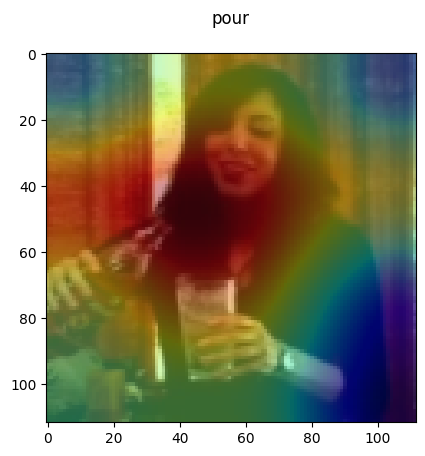

In [26]:
frame_num = 4
sample_num = 5

# Get model
opt.pretrain_path = '/scratch/tkg5kq/MARS/pretrained/MARS_orig/Kinetics/RGB_Kinetics_16f.pth'
opt.output_layers = ['avgpool', 'layer4', 'layer3']
model, parameters = generate_model(opt)

# run model on generated batch
x,y = batch
out = model(x)

# Display the sizes of the layers
for i, output_layer in enumerate(opt.output_layers):
    print(f'{output_layer}: {out[i].shape}')

# https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82
with torch.no_grad():
    data = out[2].cpu()[sample_num]

    # Interpolate from 4x4 to 112x112
    interp_data = F.interpolate(data, size=(112, 112), mode='bicubic', align_corners=False)
    # squeeze to just 4x4
    heatmap = torch.mean(interp_data, dim=(0,1)).squeeze()

    # Get the frame from the sample input and normalize
    frame = x.permute(0, 2, 3, 4, 1)[sample_num, frame_num]
    frame = frame.numpy()
    image = (frame-np.min(frame))/(np.max(frame)-np.min(frame))

    plt.figure()
    plt.title(f'{classes[y[sample_num]]}')
    plt.imshow(image)
    plt.imshow(heatmap, 'jet', interpolation='none', alpha=0.4)
    plt.show()

In [27]:
def show_sequence(seq, sample=8, title=''):
    '''Plot a sequence of images horizontally'''
    # clip is [T, H, W, 3]
    # assert (seq.shape[-1] == 3)
    fig = plt.figure(figsize=(20, 2.5))
    fig.suptitle(title, fontsize=16)
    grid = ImageGrid(fig, 111, nrows_ncols=(1, sample), axes_pad=0.1)
    for ax, img in zip(grid, seq):
        image = (img-np.min(img))/(np.max(img)-np.min(img))
        ax.imshow(image)
        ax.set_axis_off()
    plt.show()
    return

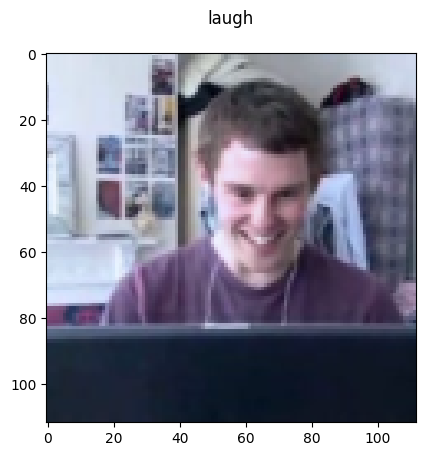

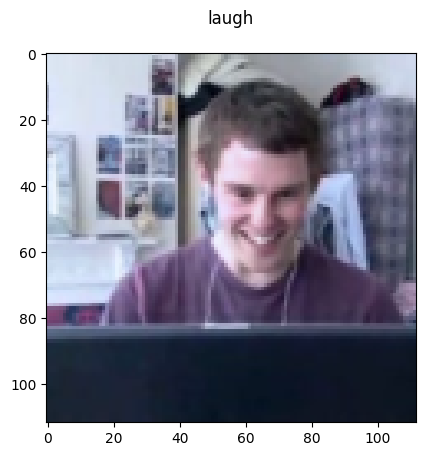

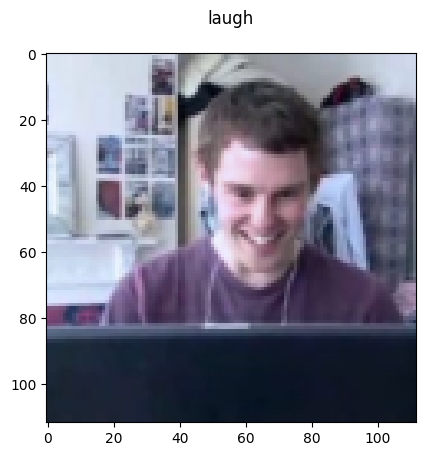

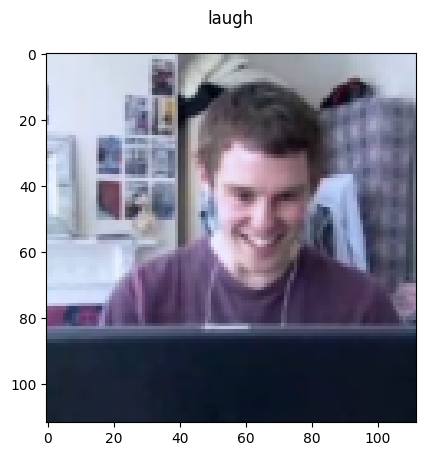

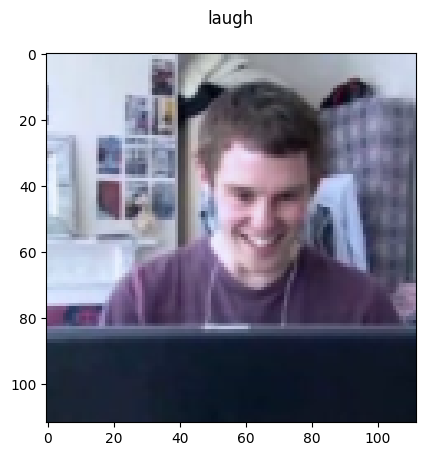

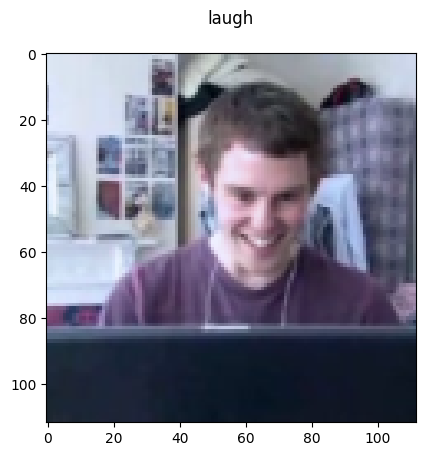

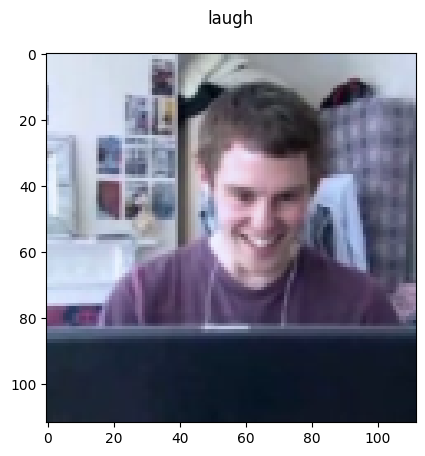

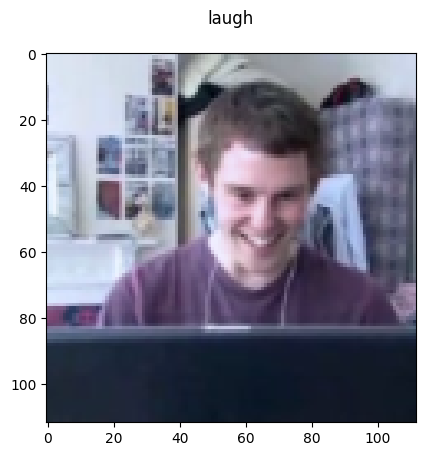

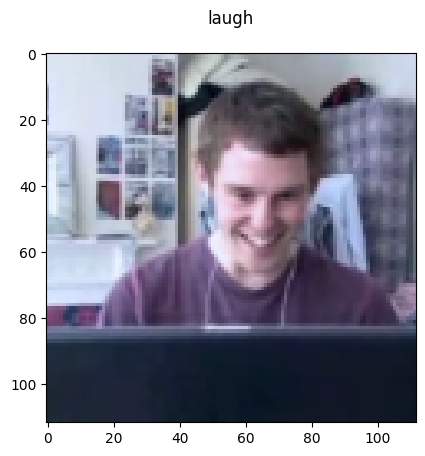

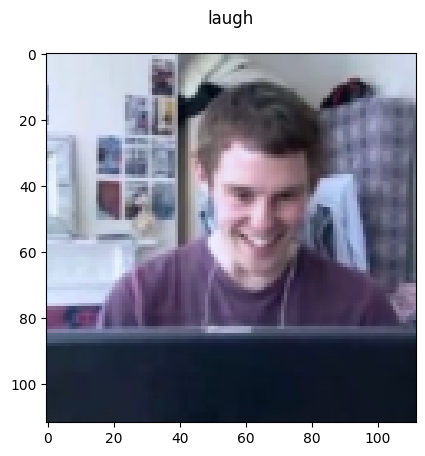

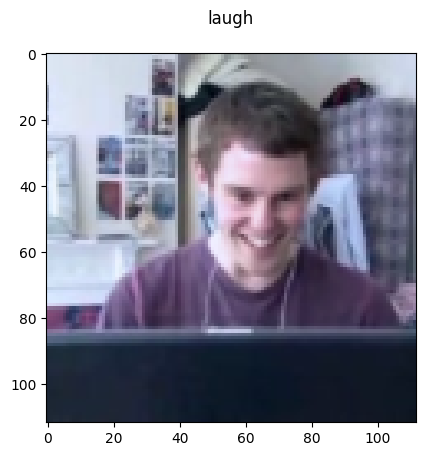

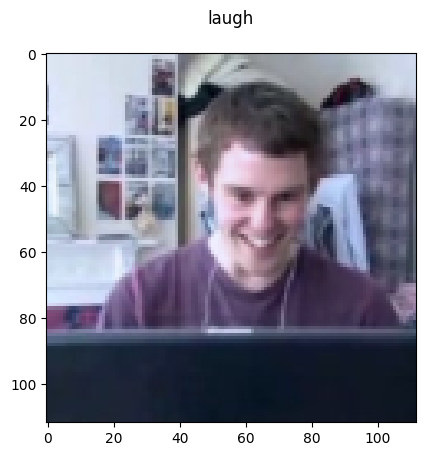

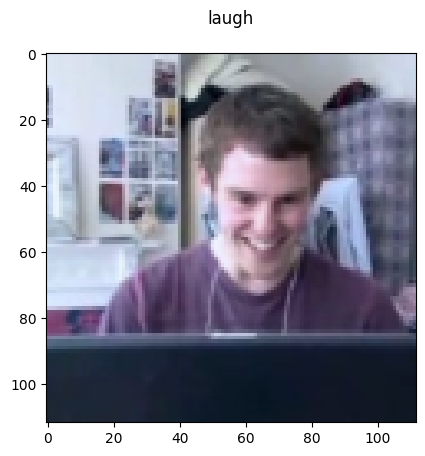

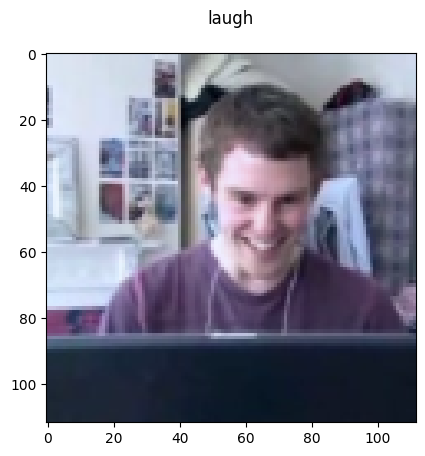

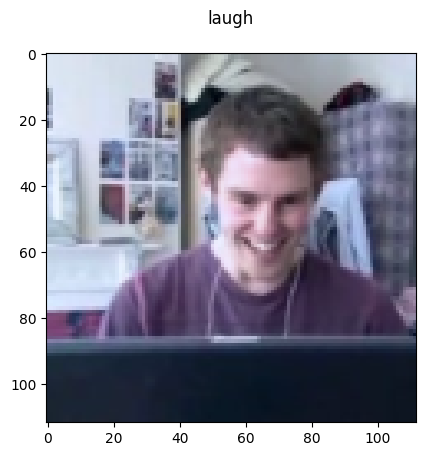

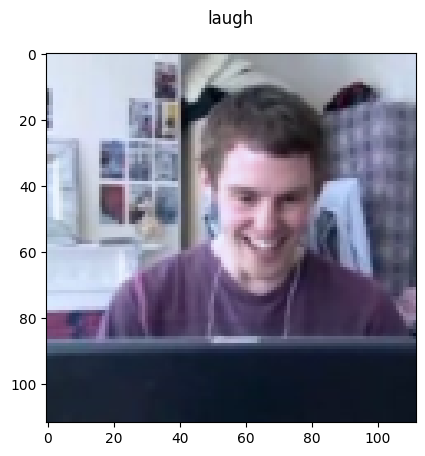

In [30]:
sample1 = x[0].numpy()

frames = np.transpose(sample1[:3, :, :, :], axes=[1, 2, 3, 0])
image = frames[0, :, :, :]

for image in frames:
    # Normalize between 0 and 1
    image = (image-np.min(image))/(np.max(image)-np.min(image))
    plt.figure()
    plt.title(f'{classes[y[0]]}')
    plt.imshow(image)
    plt.show()

In [32]:
full_path = '/scratch/tkg5kq/mmaction2/data/hmdb51/videos/hug/Calins_gratuits_a_Paris_-_Free_Hugs_France_-_version_longue_hug_u_cm_np2_le_med_9.avi' 
vid_path = 'hug/Calins_gratuits_a_Paris_-_Free_Hugs_France_-_version_longue_hug_u_cm_np2_le_med_9.avi'

In [33]:

args = dummy()
args.out_dir = './'
args.use_opencv = True

act_name = osp.basename(osp.dirname(vid_path))
out_full_path = osp.join(args.out_dir, act_name)

run_success = -1

act_name, out_full_path


('hug', './hug')

In [34]:
# Not like using denseflow,
# Use OpenCV will not make a sub directory with the video name
video_name = osp.splitext(osp.basename(vid_path))[0]
out_full_path = osp.join(out_full_path, video_name)

vr = mmcv.VideoReader(full_path)
wtsu = True
if wtsu:
    vr_tsu = np.transpose(vr, axes=[1, 0, 2, 3])
elif htsu:
    vr_tsu = np.transpose(vr, axes=[2, 1, 0, 3])

np.shape(vr), np.shape(vr_tsu)

((54, 240, 320, 3), (240, 54, 320, 3))

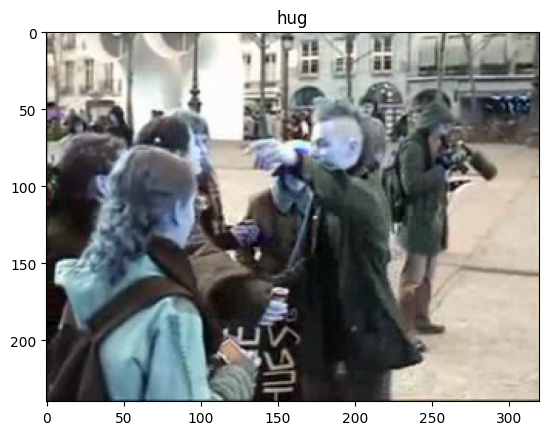

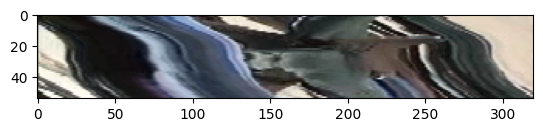

In [35]:
plt.figure()
plt.imshow(vr[0])
plt.title('hug')
plt.show()

plt.figure()
plt.imshow(vr_tsu[120])
plt.show()